In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sn
import json
import glob, os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from numpy.random import seed
from scipy.stats import kruskal
from scipy.stats import levene

from termcolor import colored
import my_plots
from matplotlib.pylab import savefig

In [2]:
# plot settings

lw = 1.5

fs = 13

params = {
    'axes.labelsize': fs,
    'font.size': fs,
    'legend.fontsize': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'text.usetex': False,
    'figure.figsize': [6, 6],
    'boxplot.boxprops.linewidth' : lw,
    'boxplot.whiskerprops.linewidth' : lw,
    'boxplot.capprops.linewidth' : lw,
    'boxplot.medianprops.linewidth' : lw,
    'text.usetex' : True,
    'font.family' : 'serif',

   }
mpl.rcParams.update(params)

In [3]:
def dfFromJSON(file):
    with open(file) as f:
        temp = []
        for line in f:
            temp.append(json.loads(line))
            
    df = pd.io.json.json_normalize(temp[0]['allLogs'])
    df.columns = df.columns.map(lambda x: x.split("*.")[-1])
    return df

In [4]:
def appendToLogs(file, log, _type):
    df = dfFromJSON(file)
    log[_type].append(df)

# Import data

In [5]:
path_to_folder = "/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Haptics_Y/"
subjects = glob.glob(path_to_folder + "*/")

logs = {}
for curr in subjects:
    logs[curr] = []
    
subjects.sort()

## Remove outliers

In [6]:
# # used to remove outliers

# subjects.remove(subjects[5])
# subjects.remove(subjects[4])

# logs = {}
# for curr in subjects:
#     logs[curr] = []
    
# subjects

In [7]:
EXP_N_THOMAS = 4
EXP_N = 5

for subject in subjects:
#     print(subject)
    files = glob.glob(subject+"*.json")
    files.sort()
    
    if len(files) != EXP_N and len(files) != EXP_N_THOMAS:
        print(subject)
        print('wrong number of experiments!')
        break
    for file in files:
        print('.')
        logs[subject].append(dfFromJSON(file))

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [8]:
fields = ['first motion', 'last motion', 'first remote', 'last remote']
interfaces = ['motion', 'remote']

sub_remote = [x for x in subjects if 'Controller' in x]
sub_motion = [x for x in subjects if 'Motion' in x]

t = [logs[x] for x in sub_motion]
logs['motion'] = []
for i in t:
    for j in i:
        logs['motion'].append(j)

t = [logs[x] for x in sub_remote]
logs['remote'] = []
for i in t:
    for j in i:
        logs['remote'].append(j)

logs['first motion'] = [logs[x][0] for x in sub_motion]
logs['last motion'] = [logs[x][-1] for x in sub_motion]
logs['first remote'] = [logs[x][0] for x in sub_remote]
logs['last remote'] = [logs[x][-1] for x in sub_remote]

# Analysis scripts

In [9]:
def t_test_kruskal(X, Y):
    
    # Kruskal-Wallis H-test
    
    # seed the random number generator
    seed(1)
    
    # compare samples
    stat, p = kruskal(X, Y)
    
    return [stat, p]

def t_test_levene(X, Y):
    
    # Kruskal-Wallis H-test
    
    # seed the random number generator
    seed(1)
    
    # compare samples
    stat, p = levene(X, Y)
    
    return [stat, p]

def str_from_p(p):
    
    if p<0.01:
        add_str = ' !!!!!!!!!!'
    elif p<0.05:
        add_str = ' !!!!!!'
    elif p<0.1:
        add_str = ' !'
    else:
        add_str = ''
        
    return add_str

def print_p(p):
    
    col = None
    
    if p<0.01:
        col = 'green'
    elif p<0.05:
        col = 'yellow'
    elif p<0.1:
        col = 'red'
        
    if col is not None:
        print(colored('p = '+ str(p) + str_from_p(p), col))
    else:
        print('p = '+ str(p) + str_from_p(p))

def runBasicAnalysis(f):
    
    var = {}

    var['means'] = []
    var['stds'] = []

    for i in fields:
        var[i] = []
        for j in logs[i]:
            var[i].append(f(j))
        print(i)
        print(var[i])

        var['means'].append(np.mean(var[i]))
        var['stds'].append(np.std(var[i]))

        print('mean = ', var['means'][-1])
        print('std = ', var['stds'][-1])

        print()
        
            
    for idx,i in enumerate(fields):
        for j in fields[idx+1:]:
            if i != j:
                
                t, p = t_test_kruskal(var[i],var[j])
                
                print (i,j)
                print_p(p)
            
    var['diff mot'] = 1-np.array(var['last motion'])/np.array(var['first motion'])
    var['diff rem'] = 1-np.array(var['last remote'])/np.array(var['first remote'])

    print()
    print('motion ratio')
    print(var['diff mot'])
    print(np.mean(var['diff mot']))
    print(np.std(var['diff mot']))
    print()
    print('remote ratio')
    print(var['diff rem'])
    print(np.mean(var['diff rem']))
    print(np.std(var['diff rem']))

    t, p = t_test_kruskal(var['diff mot'], var['diff rem'])

    print()
    print('p = ', p, str_from_p(p))
            
    var['diff first'] = 1-np.array(var['first motion'])/np.array(var['first remote'])
    var['diff last'] = 1-np.array(var['last motion'])/np.array(var['last remote'])

    print()
    print('firts ratio')
    print(var['diff first'])
    print(np.mean(var['diff first']))
    print(np.std(var['diff first']))
    print()
    print('last ratio')
    print(var['diff last'])
    print(np.mean(var['diff last']))
    print(np.std(var['diff last']))

    t, p = t_test_kruskal(var['diff first'], var['diff last'])

    print()
    print('p = ', p, str_from_p(p))
            
    return var

def runHapticsXAnalysis(f):
    
    var = {}

    var['means'] = []
    var['stds'] = []

    for i in interfaces:
        var[i] = []
        for j in logs[i]:
            var[i].append(f(j))
        print(i)
        print(var[i])

        var['means'].append(np.mean(var[i]))
        var['stds'].append(np.std(var[i]))

        print('mean = ', var['means'][-1])
        print('std = ', var['stds'][-1])

        print()
        
            
    for idx,i in enumerate(interfaces):
        for j in interfaces[idx+1:]:
            if i != j:
                
                t, p = t_test_kruskal(var[i],var[j])
                print_p(p)
                
    return var

def runHapticsYAnalysis(f):
    
    varX = {}
    varZ = {}

    varX['means'] = []
    varX['stds'] = []
    varZ['means'] = []
    varZ['stds'] = []

    for i in interfaces:
        varX[i] = []
        varZ[i] = []
        for j in logs[i]:
            varX[i].append(f(j)[0])
            varZ[i].append(f(j)[1])
        print(i)
        print(varX[i])
        print(varZ[i])

        varX['means'].append(np.mean(varX[i]))
        varX['stds'].append(np.std(varX[i]))
        varZ['means'].append(np.mean(varZ[i]))
        varZ['stds'].append(np.std(varZ[i]))

        print('mean = ', varX['means'][-1])
        print('std = ', varX['stds'][-1])
        print('mean = ', varZ['means'][-1])
        print('std = ', varZ['stds'][-1])

        print()
        
            
    for idx,i in enumerate(interfaces):
        for j in interfaces[idx+1:]:
            if i != j:
                
                tX, pX = t_test_kruskal(varX[i],varX[j])
                tY, pY = t_test_kruskal(varZ[i],varZ[j])
                
                print('')
                print(i,j, ' X')
                print_p(pX)
                print('')
                print(i,j, ' Y')
                print_p(pY)
                
    return [varX, varZ]

def basic_plot(var):
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(131)
    ax.bar([0, 1, 2, 3],
       var['means'],
       yerr=var['stds'])

    plt.xticks(range(4), fields, rotation = 10)

    ax = fig.add_subplot(132)
    ax.bar([0, 1],
       [np.mean(var['diff mot']), np.mean(var['diff rem'])],
       yerr=[np.std(var['diff mot']), np.std(var['diff rem'])])
    
    plt.xticks(range(2), ['motion', 'remote'], rotation = 10)

    ax = fig.add_subplot(133)
    ax.bar([0, 1],
       [np.mean(var['diff first']), np.mean(var['diff last'])],
       yerr=[np.std(var['diff first']), np.std(var['diff last'])])
    
    plt.xticks(range(2), ['first', 'last'], rotation = 10)

In [10]:
def moving_average(data_set, periods=3, fill_with_zeros = True):
    
    if data_set.size < periods:
        return data_set
    
    if isinstance(data_set, pd.DataFrame):
        print('a')
        data_set.index = range(len(data_set))

    weights = np.ones(periods) / periods
    
    ma = np.convolve(data_set, weights, mode='valid')

    if fill_with_zeros:
        fill_before = np.ones(int(np.ceil((len(data_set) - len(ma))/2))) * data_set[0]
        fill_after = np.ones(int(np.floor((len(data_set) - len(ma))/2))) * data_set[-1]
        ma = np.hstack([fill_before, ma, fill_after])
    
    return ma

def filter_position(df, steps):
    
    l = moving_average(df['dronePosition.x'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.x'] = np.append([l[0]]*(steps-1), l)
    l = moving_average(df['dronePosition.y'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.y'] = np.append([l[0]]*(steps-1), l)
    l = moving_average(df['dronePosition.x'], periods=steps, fill_with_zeros = False)
    df['dronePositionFiltered.x'] = np.append([l[0]]*(steps-1), l)
    return df

def running_average(signal, steps):
    
    l = moving_average(signal, periods=steps, fill_with_zeros = False)
    out = np.append([l[0]]*(steps-1), l)
    return out

# Plot Trajectories

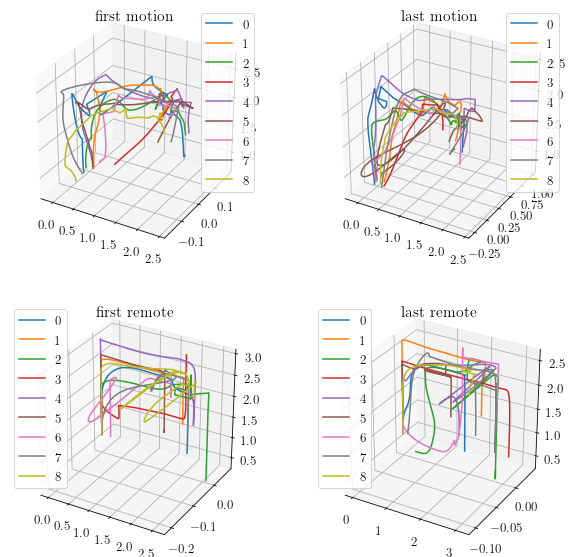

In [11]:
mpl.rcParams.update(params)

plt.figure(figsize = [10,10])

for idx,i in enumerate(fields):
    ax = plt.subplot(2, 2, 1+idx, projection='3d')
    for idx1,log in enumerate(logs[i]):
        ax.plot(log['dronePosition.x'],log['dronePosition.z'],log['dronePosition.y'], label = str(idx1))
#         print(len(log))
    plt.legend()
    plt.title(fields[idx])
#     define_plot_pos(ax)

# Time analysis

first motion
[28.649944305419922, 24.625800132751465, 25.264503479003906, 5.387521743774414, 26.888071060180664, 22.351208686828613, 19.700337409973145, 9.877029418945312, 34.67607498168945]
mean =  21.93561013539632
std =  8.658104840090244

last motion
[40.601287841796875, 27.728118896484375, 543.729736328125, 11.437896728515625, 17.663665771484375, 29.352088928222656, 17.726730346679688, 19.064971923828125, 19.538848876953125]
mean =  80.76037173800998
std =  163.88446233830376

first remote
[9.950272560119629, 16.689370155334473, 35.801780700683594, 20.225828170776367, 16.25072956085205, 16.113847732543945, 22.938923835754395, 11.452423095703125, 25.050647735595703]
mean =  19.385980394151474
std =  7.413785789851415

last remote
[12.163619995117188, 16.626541137695312, 29.01397705078125, 15.400901794433594, 14.088851928710938, 27.290252685546875, 23.176742553710938, 22.214157104492188, 14.86419677734375]
mean =  19.42658233642578
std =  5.789774587039535

first motion last motion


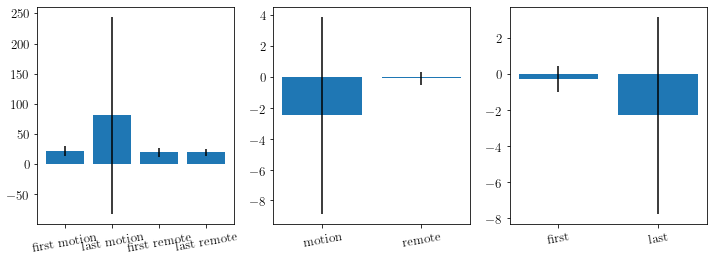

In [12]:
def compTime(df):
    return df['absoluteTime'].iloc[-1] - df['absoluteTime'].iloc[0]
time = runBasicAnalysis(compTime)
basic_plot(time)

# Distance Analysis

first motion
[5.098863687054418, 4.157523464442666, 4.148447016616543, 1.8649499232741085, 5.964647896592706, 4.847376895381771, 3.573238318376739, 4.858727736218353, 3.64910077179558]
mean =  4.2403195233058755
std =  1.1011896202909544

last motion
[5.186894038785164, 4.102428808017276, 4.96348219541103, 2.4882942602992117, 4.986377730232071, 8.080246262103865, 3.863677384941039, 4.784862384043054, 2.979403609375167]
mean =  4.603962963689764
std =  1.51464628605283

first remote
[4.992961404643115, 4.87813108389816, 7.9022419239030395, 5.01434952431377, 6.570326794488793, 4.907003095605582, 3.8979491078753767, 5.8418664881787965, 6.024891713019608]
mean =  5.558857903991804
std =  1.1093265874415132

last remote
[4.633908962380151, 5.492032067633237, 8.365070138503187, 5.909480085395697, 5.439478758457503, 5.710626364461825, 6.2372107582272385, 9.067731028319752, 4.589068559674238]
mean =  6.160511858116981
std =  1.4662878884899697

first motion last motion
p = 0.7572777496236265
f

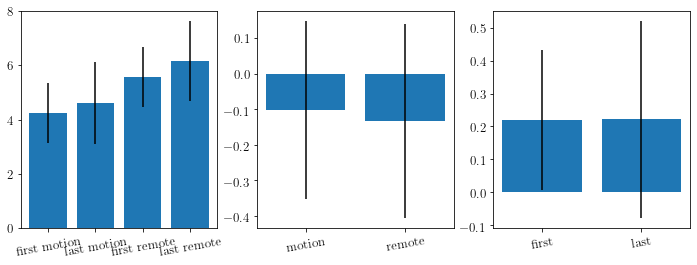

In [13]:
def compDist(df):
    
    steps = 10
    
    df['dronePositionFiltered.x'] = running_average(df['dronePosition.x'], steps)
    df['dronePositionFiltered.y'] = running_average(df['dronePosition.y'], steps)
    df['dronePositionFiltered.z'] = running_average(df['dronePosition.z'], steps)
    
    x = df['dronePositionFiltered.x'].values
    y = df['dronePositionFiltered.y'].values
    z = df['dronePositionFiltered.z'].values

    dx = np.diff(x)
    dy = np.diff(y)
    dz = np.diff(z)

    dd = np.sqrt(dx**2+dy**2+dz**2)
    d = np.sum(dd)

    return d

dist = runBasicAnalysis(compDist)
basic_plot(dist)

# Velocity Analysis

first motion
[0.16670769214327658, 0.15444131929484067, 0.1522259428224899, 0.31081427924418026, 0.17339110366309832, 0.21628032774812062, 0.1645653304755632, 0.4658359097220933, 0.10180964321074738]
mean =  0.21178572759160116
std =  0.10489930680005666

last motion
[0.11315042012906794, 0.1245361670722627, 0.005686258027801018, 0.16689511572244495, 0.27331753853850066, 0.26967946212066274, 0.21864408634788524, 0.20157279981544973, 0.1436362162763452]
mean =  0.16856867378338
std =  0.07955270059385125

first remote
[0.43662315949168923, 0.2576084152766314, 0.21752311106886968, 0.25260561680406024, 0.36698445882399633, 0.28395295326891806, 0.15599656682275584, 0.43469785448682546, 0.2333825960660968]
mean =  0.2932638591233159
std =  0.09259591021431052

last remote
[0.3645480848359363, 0.27879900469078706, 0.2787208107675681, 0.3877250213019388, 0.34124055320823604, 0.19270856954700508, 0.271426170187324, 0.37365037706451465, 0.2613116368089173]
mean =  0.30557002537913636
std =  0.0

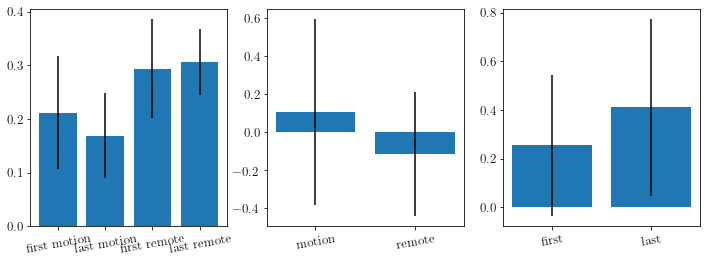

In [14]:
def compVel(df):
    x = df['dronePositionFiltered.x'].values
    y = df['dronePositionFiltered.y'].values
    z = df['dronePositionFiltered.z'].values
    t = df['absoluteTime'].values

    dx = np.diff(x)
    dy = np.diff(y)
    dz = np.diff(z)
    dt = np.diff(t)
    
    vx = np.append([0],dx/dt)
    vy = np.append([0],dy/dt)
    vz = np.append([0],dz/dt)
    
    df['droneVelocity.x'] = vx
    df['droneVelocity.y'] = vy
    df['droneVelocity.z'] = vz
    
    steps = 20    
    
    df['droneVelocityFiltered.x'] = running_average(df['droneVelocity.x'], steps)
    df['droneVelocityFiltered.y'] = running_average(df['droneVelocity.y'], steps)
    df['droneVelocityFiltered.z'] = running_average(df['droneVelocity.z'], steps)

    dv = np.sqrt(df['droneVelocityFiltered.x'][100:]**2+df['droneVelocityFiltered.y'][100:]**2+df['droneVelocityFiltered.z'][100:]**2)
    
    v = np.mean(dv)
    
    return v

vel = runBasicAnalysis(compVel)
basic_plot(vel)

# Acceleration Analysis

first motion
[0.32515280376563455, 0.13626843234121394, 0.17835389696060375, 0.22544927085225464, 0.34197980596928124, 0.4317578644098495, 0.3814614387876449, 0.6609436086040491, 0.20006463647526831]
mean =  0.32015908424064443
std =  0.1528123568727218

last motion
[0.22735718381419032, 0.19910352944340431, 0.008210842761670455, 0.17608185699990345, 0.47676944673481947, 0.5278289590374845, 0.4793943698111598, 0.2770301973386681, 0.23422211560875303]
mean =  0.28955538906111705
std =  0.16164502933757816

first remote
[0.42667150003425264, 0.23780413184458032, 0.25116665008073713, 0.27157838041788057, 0.44382079673342345, 0.2933684444050458, 0.17539074665406637, 0.5848233665005743, 0.2638212868204532]
mean =  0.32760503372122374
std =  0.12244602121112522

last remote
[0.3024526595399755, 0.30787136089064404, 0.29664530781107934, 0.31540356953942644, 0.41535482178037575, 0.2665788095782897, 0.2948284444111627, 0.5097614956220475, 0.31632623079710037]
mean =  0.33613585555223346
std =  

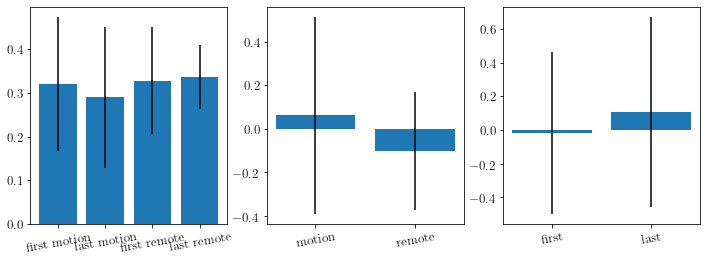

In [15]:
def compAcc(df):
    vx = df['droneVelocityFiltered.x'].values
    vy = df['droneVelocityFiltered.y'].values
    vz = df['droneVelocityFiltered.z'].values
    t = df['absoluteTime'].values
    
    dvx = np.diff(vx)
    dvy = np.diff(vy)
    dvz = np.diff(vz)
    dt = np.diff(t)
    
    ax = np.append([0],dvx/dt)
    ay = np.append([0],dvy/dt)
    az = np.append([0],dvz/dt)
    
    df['droneAcceleration.x'] = ax
    df['droneAcceleration.y'] = ay
    df['droneAcceleration.z'] = az
    
    steps = 30    
    
    df['droneAccelerationFiltered.x'] = running_average(df['droneAcceleration.x'], steps)
    df['droneAccelerationFiltered.y'] = running_average(df['droneAcceleration.y'], steps)
    df['droneAccelerationFiltered.z'] = running_average(df['droneAcceleration.z'], steps)

    da = np.sqrt(df['droneAccelerationFiltered.x'][100:]**2+df['droneAccelerationFiltered.y'][100:]**2+df['droneAccelerationFiltered.z'][100:]**2)
    
    a = np.mean(da)

    return a

acc = runBasicAnalysis(compAcc)
basic_plot(acc)

# Jerk Analysis

first motion
[0.868232121309506, 0.27861313599631293, 0.39567153179775216, 0.40867013648147177, 0.8578315732871354, 1.2698941554784569, 1.2062331484744966, 1.6499121620160968, 0.6779271155960485]
mean =  0.8458872311596974
std =  0.4346892333295164

last motion
[0.6156727651655887, 0.5381729742706597, 0.01979790916294642, 0.3930798218694013, 1.3933953958077974, 1.431158438004284, 1.4918864552853972, 0.6749690111309502, 0.7314492416199125]
mean =  0.8099535569241042
std =  0.4859647319680146

first remote
[0.7383713761031163, 0.4212543279550694, 0.5154417508852206, 0.6177704053122548, 0.8513082934912841, 0.5371788912132884, 0.3926890729764551, 1.2023067287318652, 0.5864135952891789]
mean =  0.6514149379953037
std =  0.23753578246818033

last remote
[0.5566432866715202, 0.5960698732737837, 0.6566775244705224, 0.8055531442375994, 0.8571889693918429, 0.57539635627744, 0.6152943972582787, 1.0066845912138818, 0.5997880806736051]
mean =  0.696588469274275
std =  0.14748767228763984

first mot

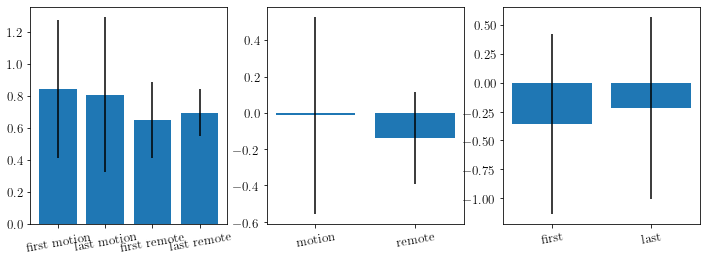

In [16]:
def compJerk(df):
    ax = df['droneAccelerationFiltered.x'].values
    ay = df['droneAccelerationFiltered.y'].values
    az = df['droneAccelerationFiltered.z'].values
    t = df['absoluteTime'].values
    
    dax = np.diff(ax)
    day = np.diff(ay)
    daz = np.diff(az)
    dt = np.diff(t)
    
    jx = np.append([0],dax/dt)
    jy = np.append([0],day/dt)
    jz = np.append([0],daz/dt)
    
    df['droneJerk.x'] = jx
    df['droneJerk.y'] = jy
    df['droneJerk.z'] = jz
    
    steps = 40    
    
    df['droneJerkFiltered.x'] = running_average(df['droneJerk.x'], steps)
    df['droneJerkFiltered.y'] = running_average(df['droneJerk.y'], steps)
    df['droneJerkFiltered.z'] = running_average(df['droneJerk.z'], steps)

    dj = np.sqrt(df['droneJerkFiltered.x'][100:]**2+df['droneJerkFiltered.y'][100:]**2+df['droneJerkFiltered.z'][100:]**2)
    
    
    j = np.mean(dj)

    return j

jerk = runBasicAnalysis(compJerk)
basic_plot(jerk)

# Energy Analysis

first motion
[284.38103733211983, 185.81123336681736, 202.30224338905035, 92.02629231511257, 305.824406340474, 305.2165193679148, 211.7866450690766, 241.6964431959001, 251.57742533398425]
mean =  231.18024952338334
std =  64.15458838623402

last motion
[328.11489685756345, 193.66537262157533, 273.8598023190073, 108.44135567459989, 267.2434894766178, 669.7877780308264, 199.93364303098588, 272.58759977636436, 181.21129773000206]
mean =  277.2050261686158
std =  151.83707939050635

first remote
[168.6204502571526, 163.78120110166137, 256.528325530028, 162.23870323191827, 216.44169457004227, 126.70861680908115, 132.65163638780882, 272.72252994006266, 325.27571075141776]
mean =  202.7743187310192
std =  64.98623903353634

last remote
[162.87879844196772, 204.23449477486312, 309.6249764834771, 253.22868635320182, 266.7132310330948, 280.86678246851983, 239.24612431882173, 281.8297989282766, 248.30335593387517]
mean =  249.65847208178866
std =  41.650461633258715

first motion last motion
p = 

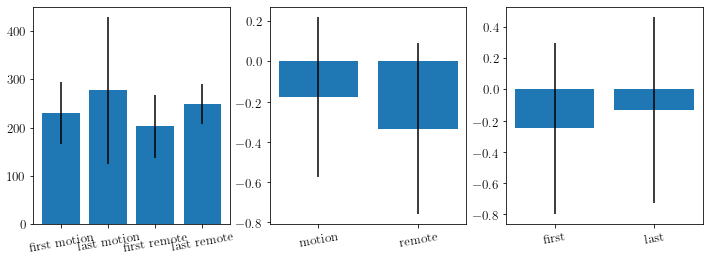

In [17]:
def compEnergy(df):
    df['controlInput'] = np.sqrt(df['controlSpeed.x']**2+df['controlSpeed.y']**2+df['controlSpeed.z']**2)
    return df['controlInput'].sum()

energy = runBasicAnalysis(compEnergy)
basic_plot(energy)

# Power Analysis

first motion
[29.279463707967828, 7.78547994345891, 4.997590440576815, 1.9018079443014941, 19.507293535757867, 24.6786501562533, 24.266486090193162, 11.878154782896086, 26.04214195002001]
mean =  16.704118727936162
std =  9.620357896634264

last motion
[34.8724644654678, 10.285467368276214, 9.762697106917548, 3.360647294454775, 17.251815405725765, 32.947677847077586, 20.288081594778212, 13.177371101720388, 13.797333813399337]
mean =  17.30483955531307
std =  9.956332257621735

first remote
[4.720277387357631, 4.067306362645802, 7.208436436587596, 4.878230874474367, 5.689337954671332, 3.6628680432307354, 4.494647596803654, 6.843471994197072, 9.686612506614622]
mean =  5.694576572953646
std =  1.8067609862164669

last remote
[5.502442168071719, 4.65334844734449, 9.172103541761757, 7.143759684636431, 7.255393839119461, 9.811063243250572, 6.827921039027211, 8.132814915280308, 6.828175950911643]
mean =  7.258558092155955
std =  1.5346440016060103

first motion last motion
p = 0.894625809546

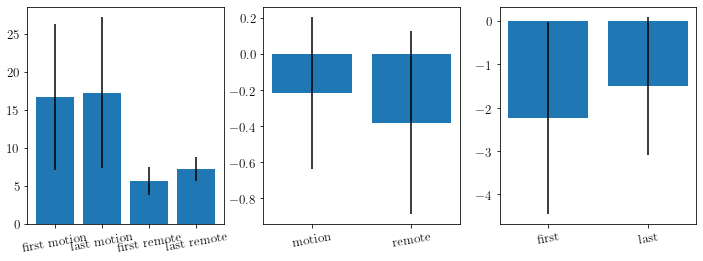

In [18]:
def compDEnergy(df):
    dEnergy = np.abs(np.diff(df['controlInput']))
    return np.sum(dEnergy)

dEnergy = runBasicAnalysis(compDEnergy)
basic_plot(dEnergy)

# Collision Analysis

In [19]:
coll_df = pd.read_csv('/Volumes/GoogleDrive/My Drive/Matteo/EPFL/LIS/PhD/Bidirectional_wearable_interface/DATA/Haptics/Bidir - haptics ZY collisions - Sheet1.csv')

In [20]:
coll = {}

coll['motion'] = coll_df[coll_df['Interface']=='Motion']
coll['remote'] = coll_df[coll_df['Interface']=='Remote']


coll['first motion'] = coll['motion'][coll['motion']['Run']==1]
coll['last motion'] = coll['motion'][coll['motion']['Run']==5]
coll['first remote'] = coll['remote'][coll['remote']['Run']==1]
coll['last remote'] = coll['remote'][coll['remote']['Run']==5]



consider all runs

mean motion =  2.3333333333333335
std motion =  0.816496580927726
mean remote =  2.5555555555555554
std remote =  0.8314794192830981

total motion =  21.0
total remote =  23.0

p = 0.5087764159758276

consider first runs

mean motion =  0.5555555555555556
std motion =  0.4969039949999533
mean remote =  0.4444444444444444
std remote =  0.4969039949999533

total motion =  5.0
total remote =  4.0

p = 0.6468641853669347

consider last runs

mean motion =  0.3333333333333333
std motion =  0.4714045207910317
mean remote =  0.6666666666666666
std remote =  0.4714045207910317

total motion =  3.0
total remote =  6.0

p = 0.1693272972120591

consider diff runs

[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
mean motion =  0.2222222222222222
std motion =  0.7856742013183863
mean remote =  -0.2222222222222222
std remote =  0.41573970964154905

total motion =  2.0
total remote =  -2.0

p = 0.16932729721205866


Text(0.5, 1.0, 'Collisions - different first-last')

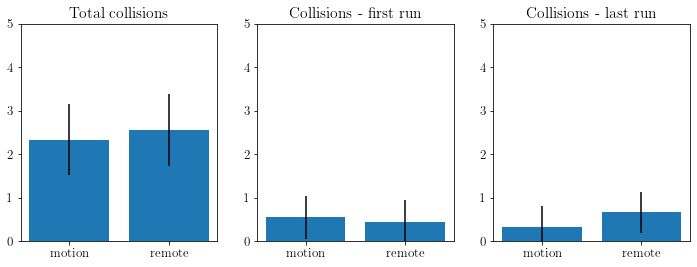

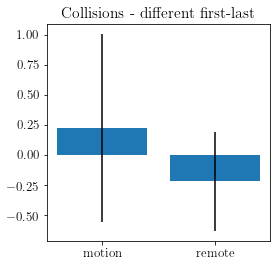

In [21]:
def compute_mean_std_collisions(data_m, data_r):
    
    coll_per_sub_m = []
    
    for sub in np.unique(data_m['Subject']):
        sub_coll = data_m[data_m['Subject']==sub]
        
        coll_per_sub_m.append(sub_coll['Collided Y'].sum())
        
    coll_per_sub_r = []
    
    for sub in np.unique(data_r['Subject']):
        sub_coll = data_r[data_r['Subject']==sub]
        
        coll_per_sub_r.append(sub_coll['Collided Y'].sum())
    
    mean_m = np.mean(coll_per_sub_m)
    std_m = np.std(coll_per_sub_m)
    mean_r = np.mean(coll_per_sub_r)
    std_r = np.std(coll_per_sub_r)

    print('mean motion = ', mean_m)
    print('std motion = ', std_m)
    print('mean remote = ', mean_r)
    print('std remote = ', std_r)
    print('')
    print('total motion = ', np.sum(coll_per_sub_m))
    print('total remote = ', np.sum(coll_per_sub_r))
    print('')

    t, p = t_test_kruskal(coll_per_sub_m, coll_per_sub_r)

    print_p(p)
    
    return [coll_per_sub_m, coll_per_sub_r]

def compute_mean_std_collisions_diff(data_m, data_r):
    
    coll_per_sub_m_init = []
    coll_per_sub_m_fin = []
    
    for sub in np.unique(data_m['Subject']):
        sub_coll = data_m[data_m['Subject']==sub]
        
        coll_per_sub_m_init.append(sub_coll['Collided Y'].values[0])
        coll_per_sub_m_fin.append(sub_coll['Collided Y'].values[-1])
        
    coll_per_sub_r_init = []
    coll_per_sub_r_fin = []
    
    for sub in np.unique(data_r['Subject']):
        sub_coll = data_r[data_r['Subject']==sub]
        
        coll_per_sub_r_init.append(sub_coll['Collided Y'].values[0])
        coll_per_sub_r_fin.append(sub_coll['Collided Y'].values[-1])
        
    diff_m = np.array(coll_per_sub_m_init) - np.array(coll_per_sub_m_fin)
    diff_r = np.array(coll_per_sub_r_init) - np.array(coll_per_sub_r_fin)
    
    mean_m = np.mean(diff_m)
    std_m = np.std(diff_m)
    mean_r = np.mean(diff_r)
    std_r = np.std(diff_r)
    
    print(coll_per_sub_m_init)

    print('mean motion = ', mean_m)
    print('std motion = ', std_m)
    print('mean remote = ', mean_r)
    print('std remote = ', std_r)
    print('')
    print('total motion = ', np.sum(diff_m))
    print('total remote = ', np.sum(diff_r))
    print('')

    t, p = t_test_kruskal(diff_m, diff_r)

    print_p(p)
    
    return [diff_m, diff_r]

print('')
print('consider all runs')
print('')
all_m, all_r = compute_mean_std_collisions(coll['motion'], coll['remote'])
    
print('')
print('consider first runs')
print('')
first_m, first_r = compute_mean_std_collisions(coll['first motion'], coll['first remote'])
    
print('')
print('consider last runs')
print('')
last_m, last_r = compute_mean_std_collisions(coll['last motion'], coll['last remote'])
    
print('')
print('consider diff runs')
print('')
diff_m, diff_r = compute_mean_std_collisions_diff(coll['motion'], coll['remote'])


    
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)
ax.bar([0, 1],
   [np.mean(all_m), np.mean(all_r)],
      yerr = [np.std(all_m), np.std(all_r)])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 5])
plt.title('Total collisions')

ax = fig.add_subplot(132)
ax.bar([0, 1],
   [np.mean(first_m), np.mean(first_r)],
      yerr = [np.std(first_m), np.std(first_r)])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 5])
plt.title('Collisions - first run')

ax = fig.add_subplot(133)
ax.bar([0, 1],
   [np.mean(last_m), np.mean(last_r)],
      yerr = [np.std(last_m), np.std(last_r)])

plt.xticks(range(2), ['motion', 'remote'])
plt.ylim([0, 5])
plt.title('Total collisions')
plt.title('Collisions - last run')

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.bar([0, 1],
   [np.mean(diff_m), np.mean(diff_r)],
      yerr = [np.std(diff_m), np.std(diff_r)])

plt.xticks(range(2), ['motion', 'remote'])
plt.title('Total collisions')
plt.title('Collisions - different first-last')

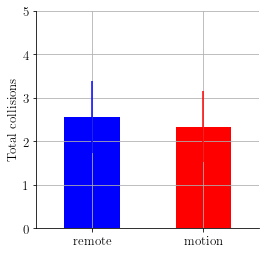

In [22]:

c1 = 'b'
c2 = 'r'

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.bar([1],
   [np.mean(all_r),],
      yerr = [np.std(all_r)], color =c1, ecolor = c1, width=0.5 )
ax.bar([2],
   [np.mean(all_m)],
      yerr = [np.std(all_m)], color =c2, ecolor = c2, width=0.5 )

plt.xticks([1,2], ['remote', 'motion'])
plt.ylim([0, 5])
plt.xlim([0.5, 2.5])
plt.ylabel('Total collisions')
plt.grid()

        
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

savefig('collisions_Y.pdf', bbox_inches='tight')

## <span style="color:red">HERE RESULTS</span>

# Go-through passing Analysis

In [23]:
def comp_max_dist(df):
    
    dist_obstacle = 2
    collider = 0.5+0.5

    y_cross = dist_obstacle + collider
    
    y = df['dronePosition.y']
    
    
#     print()
    for idx,i in enumerate(y):
        if idx>0:
            if y[idx-1]>y_cross and y[idx]<y_cross:
#                 print(idx)
                break
                
    
    return [df['dronePosition.x'][idx], df['dronePosition.z'][idx]]

cross_ret = runHapticsYAnalysis(comp_max_dist)

motion
[2.423576593399048, 1.7832410335540771, 2.1033689975738525, 1.9765089750289917, 2.127129077911377, 1.8418307304382324, 1.9783519506454468, 1.8418278694152832, 1.8899714946746826, 1.8052246570587158, 2.018615961074829, 1.7538827657699585, 2.130727767944336, 1.9600868225097656, 1.8177858591079712, 1.3802027702331543, 1.7220653295516968, 1.798635482788086, 1.435656189918518, 1.5754591226577759, 2.0775678157806396, 2.0952205657958984, 2.1907029151916504, 1.8785805702209473, 1.9131425619125366, 1.7291945219039917, 1.7932817935943604, 1.6271581649780273, 1.6876198053359985, 1.7679576873779297, 1.722852349281311, 2.2923216819763184, 1.9924442768096924, 1.898862361907959, 1.9804110527038574, 1.6771869659423828, 1.4988813400268555, 1.7466046810150146, 1.6523685455322266, 1.760744571685791, 1.9300199747085571, 1.7226362228393555, 1.896193027496338, 1.8455902338027954, 1.8749381303787231]
[-0.03784526512026787, 0.006329774856567383, -0.0055482471361756325, 0.01635921187698841, -0.101620823

In [24]:
coord = ['X', 'Z']
cross = {}

cross_dic = {'X':cross_ret[0], 'Z':cross_ret[1]}
center = {'X':2, 'Z':0}

for c in coord:
    cross[c] = {}
    for i in interfaces:
        cross[c][i] = np.array(cross_dic[c][i]) - center[c]

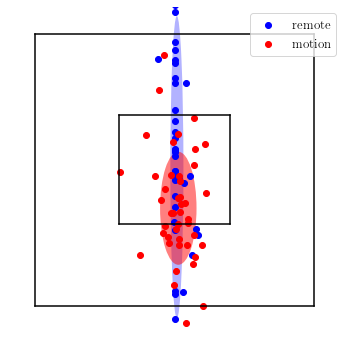

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(cross['Z']['remote'], cross['X']['remote'], color = 'b', label = 'remote')
ax.scatter(cross['Z']['motion'], cross['X']['motion'], color = 'r', label = 'motion')

l = 0.2
ax.plot([-l, -l], [-l, l] ,'k')
ax.plot([l, l], [-l, l] ,'k')
ax.plot([-l, l], [-l, -l] ,'k')
ax.plot([-l, l], [l, l] ,'k')
l = 0.5
ax.plot([-l, -l], [-l, l] ,'k')
ax.plot([l, l], [-l, l] ,'k')
ax.plot([-l, l], [-l, -l] ,'k')
ax.plot([-l, l], [l, l] ,'k')

plt.xlim([-0.6, 0.6])
plt.ylim([-0.6, 0.6])

plt.xlabel('Z [m]')
plt.ylabel('X [m]')

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.legend(loc = 'upper right')

ellipse = Ellipse((np.mean(cross['Z']['remote']), np.mean(cross['X']['remote'])), width=np.std(cross['Z']['remote'])*2,
        height=np.std(cross['X']['remote'])*2,
        alpha=0.3,
        facecolor='b', zorder=-2)
ax.add_patch(ellipse)


ellipse = Ellipse((np.mean(cross['Z']['motion']), np.mean(cross['X']['motion'])), width=np.std(cross['Z']['motion'])*2,
        height=np.std(cross['X']['motion'])*2,
        alpha=0.5,
        facecolor='r', zorder=-1)
ax.add_patch(ellipse)
        
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

savefig('cross_Y.pdf', bbox_inches='tight')

0.009256037738588121
0.5560756608901005
-0.14185263845655655
0.2079106812880978
p = 0.002348588062020376 !!!!!!!!!!
0.008189437750588013
0.02344103127651982
0.013251712157701453
0.06533015555860092
p = 6.046822195401048e-06 !!!!!!!!!!


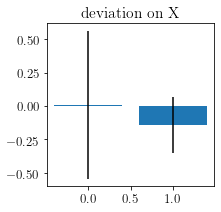

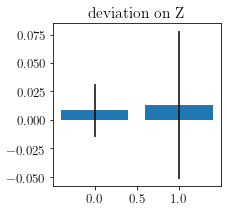

In [26]:

for c in coord:

    print(np.mean(cross[c]['remote']))
    print(np.std(cross[c]['remote']))
    print(np.mean(cross[c]['motion']))
    print(np.std(cross[c]['motion']))

    fig = plt.figure(figsize=[3,3])
    ax = fig.add_subplot(111)

    ax.bar([0,1], 
            [np.mean(cross[c]['remote']), np.mean(cross[c]['motion'])],
          yerr = [np.std(cross[c]['remote']), np.std(cross[c]['motion'])])
    plt.title('deviation on ' + c)

    print_p(t_test_levene(cross[c]['remote'], cross[c]['motion'])[1])

# TEST